In [45]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc

 
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device("mps")

model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [46]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [47]:
# load questions

file_path = "turl_test_2k_prompts_50.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [358]:
%%time

# load processed data

import os
import pickle

prefix = './tablellama10runs/'

run = 0

outlist = []
for file in os.listdir(prefix):
    if file.endswith('pickle'):
        print(file)
        with open(os.path.join(prefix, file), 'rb') as handle:
            outlist_ = pickle.load(handle)
            outlist.extend([dict(item, **{'run': run, 'pid': pid}) for pid, item in enumerate(outlist_)])
    run += 1

len(outlist)

TableLlama.3518465688.pickle
TableLlama.1238154247.pickle
TableLlama.2329726566.pickle
TableLlama.3772737819.pickle
TableLlama.1659250506.pickle
TableLlama.1674567122.pickle
TableLlama.3947840415.pickle
TableLlama.3566707448.pickle
TableLlama.3095983523.pickle
TableLlama.2922754562.pickle
CPU times: user 20.7 s, sys: 1.02 s, total: 21.7 s
Wall time: 21.7 s


1000

### check output against ground truth

In [359]:
%%time

# show results

c=0
t=0
h=0

truth = []

for idx, p in enumerate(outlist):
    c+=1
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    a = generated_text.lower().strip()
    b = p['output'].lower().strip()
    # correct
    correct = False
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    truth.append((p['run'], p['pid'], correct))

CPU times: user 8.45 s, sys: 200 ms, total: 8.66 s
Wall time: 9.27 s


In [360]:
# true, hallucinated, counted
t, h, c

(888, 4, 1000)

In [361]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct'])

<Axes: xlabel='correct', ylabel='Count'>

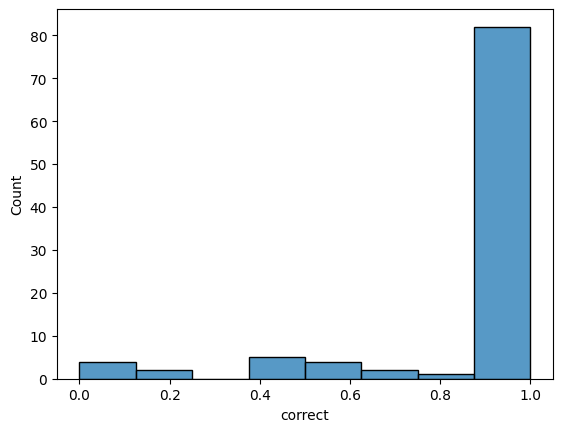

In [419]:
sns.histplot(truth.groupby('pid').correct.mean())

### sequence components alignment

In [363]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [364]:
%%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])

    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    output_seq = p['post_output_sequences'][0]

    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    instruction_match = is_sublist(instruction_seq[2:], output_seq, 'instruction')
    input_match = is_sublist(input_seq[2:], output_seq, 'input')
    question_match = is_sublist(question_seq[2:], output_seq, 'question') # maybe include 1?
    postilla_match = is_sublist(postilla_seq[2:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0], 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0] + 1) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq), len(output_seq) -1, 'generated')) # assume everything else is generated

CPU times: user 20.3 s, sys: 108 ms, total: 20.4 s
Wall time: 20.4 s


In [365]:
# check the checks (must be False)
'False' in checks

False

In [366]:
import pandas as pd
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [367]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [368]:
segments

,run,pid,start,end,segment,seq
0,0,0,0,40,preamble,0
1,0,0,41,135,instruction,1
2,0,0,136,644,input,2
3,0,0,645,1980,question,3
4,0,0,1981,2045,postilla,4
...,...,...,...,...,...,...
5995,9,99,41,135,instruction,1
5996,9,99,136,1397,input,2
5997,9,99,1398,3174,question,3
5998,9,99,3175,3239,postilla,4


### collect observables

In [369]:
shapes_pre = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    for j, pp in enumerate(p['pre_output_proba_topn']):
        shapes_pre.append((run,pid,j,'prompt',
                           len(pp['top_n_indices']),
                           p['pre_output_true_entropies'][j],
                           max(pp['top_n_probs'])))
        
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes_pre.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['pre_output_true_entropies'][jj],
                           max(pp['top_n_probs'])))

In [370]:
import pandas as pd
import numpy as np
d = pd.DataFrame(shapes_pre, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp'])

In [371]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

True

In [372]:
%%time

# attach prompt section
m = d.merge(segments, on=['run','pid'], how='left')
m = m[(m.start <= m.tok) & (m.tok <= m.end)]

CPU times: user 1.47 s, sys: 474 ms, total: 1.94 s
Wall time: 1.95 s


In [373]:
m

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq
0,0,0,0,prompt,19127,9.342692,0.011505,0,40,preamble,0
6,0,0,1,prompt,4954,6.863560,0.110962,0,40,preamble,0
12,0,0,2,prompt,9,1.748911,0.684082,0,40,preamble,0
18,0,0,3,prompt,178,4.617726,0.093811,0,40,preamble,0
24,0,0,4,prompt,5,1.100033,0.811523,0,40,preamble,0
...,...,...,...,...,...,...,...,...,...,...,...
23143721,9,99,3266,generated,1,0.007299,1.000000,3240,3270,generated,5
23143727,9,99,3267,generated,1,1.784877,1.000000,3240,3270,generated,5
23143733,9,99,3268,generated,1,3.481779,1.000000,3240,3270,generated,5
23143739,9,99,3269,generated,1,2.092228,1.000000,3240,3270,generated,5


In [374]:
# did we merge all the tokens to their segments (must be True)
d[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True).equals(m[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True))

True

In [376]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

True

### token position normalization

In [377]:
segments['length'] = segments.end - segments.start

In [378]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,40.000,0.000000,40,40,0.010386,0.010386
2,instruction,1,94.000,0.000000,94,94,0.024407,0.034794
1,input,2,2322.480,2017.818287,192,6587,0.603039,0.637833
5,question,3,1306.130,365.860694,119,3814,0.339141,0.976974
3,postilla,4,64.000,0.000000,64,64,0.016618,0.993591
0,generated,5,24.681,5.805768,15,44,0.006409,1.000000


<Axes: xlabel='length', ylabel='Count'>

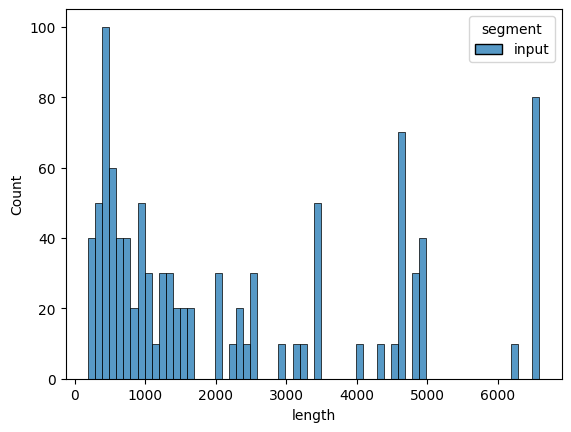

In [379]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

In [380]:
# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end


# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))


# old
# d['tok_rel'] = d.groupby('pid').tok.transform(lambda x: x / x.max())

In [381]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

### check variances

In [382]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [383]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [384]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [385]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [386]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.28056654

In [387]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.057353463

In [388]:
mm = m.copy()

### single run plots

In [389]:
m = mm[mm.run==0].copy()

In [390]:
# binning
NUM_BINS = 100

99


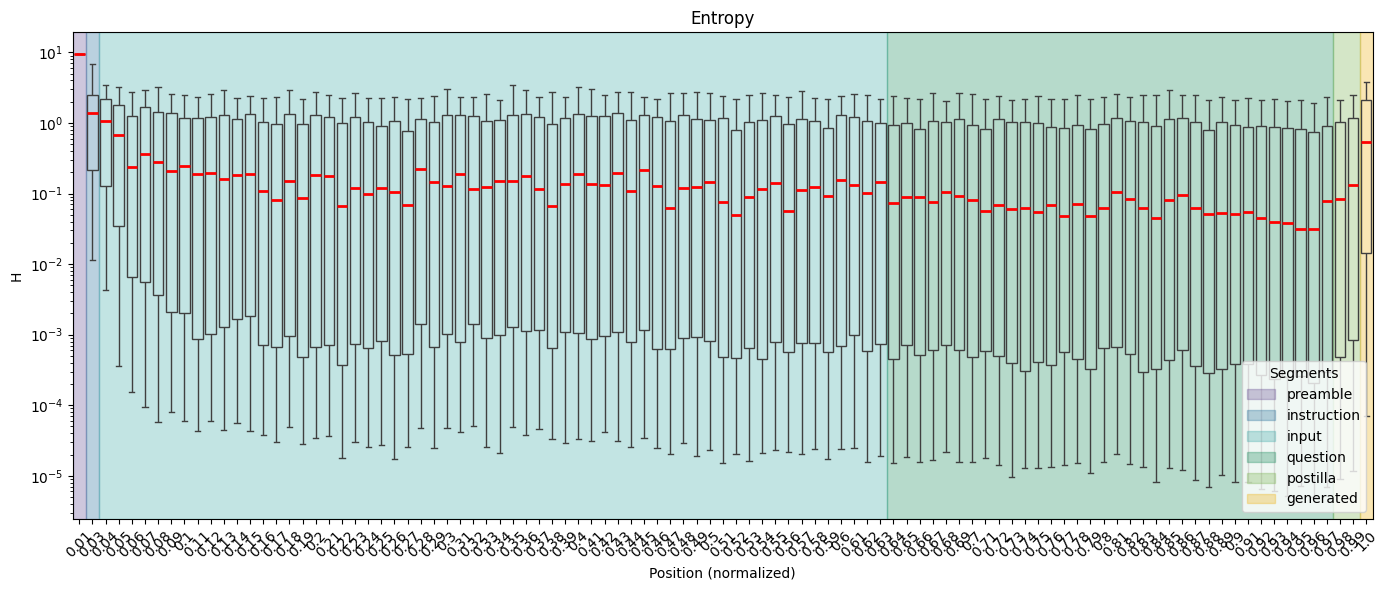

In [391]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

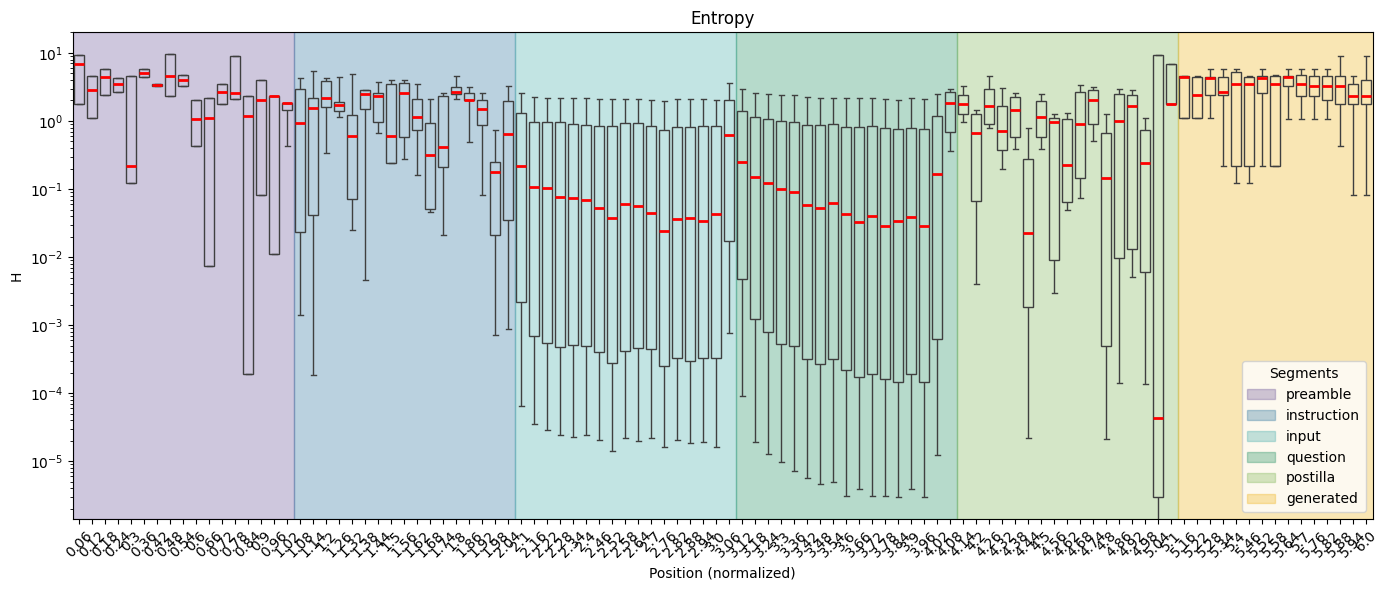

In [392]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

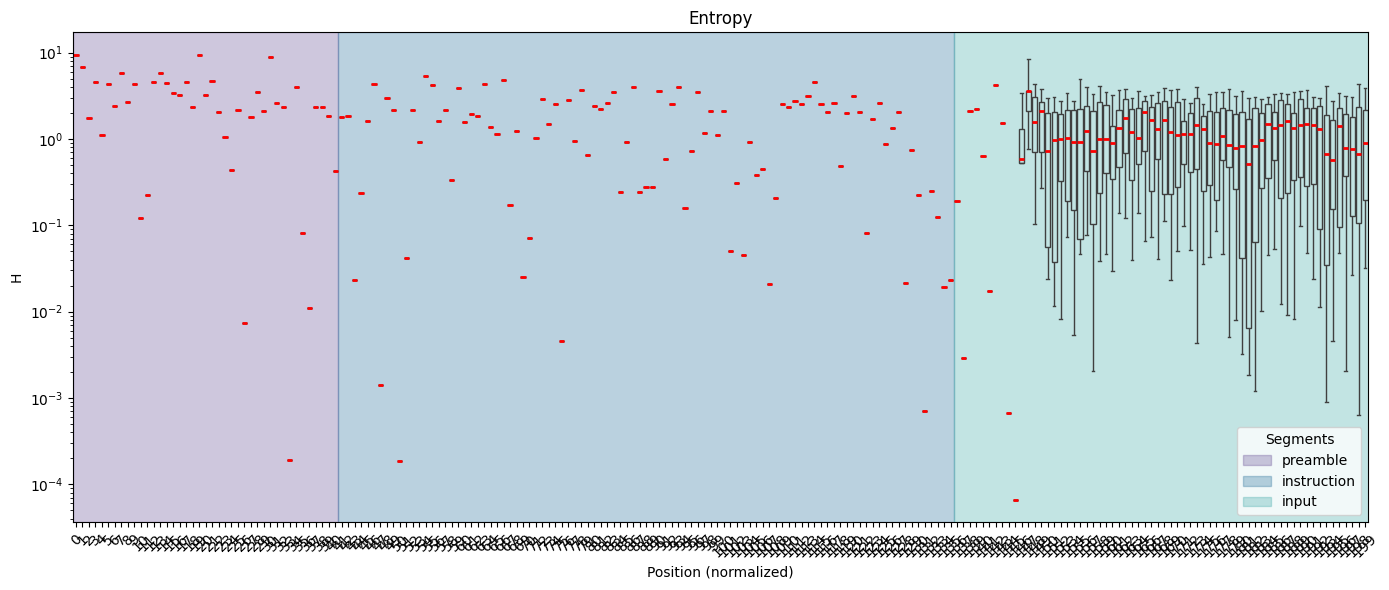

In [393]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<200]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

In [394]:
m.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [395]:
m[m.segment=='preamble'].groupby('pid').size().std()

0.0

In [396]:
m[m.segment=='instruction'].groupby('pid').size().std()

0.0

In [397]:
m[m.segment=='input'].groupby('pid').size().std()

2026.9694375115923

In [398]:
m[m.tok_rel_segm_abs<1.].true_ent.var()

5.9585185

In [399]:
df[df.tok_bin_idx==0].true_ent.var()

nan

99


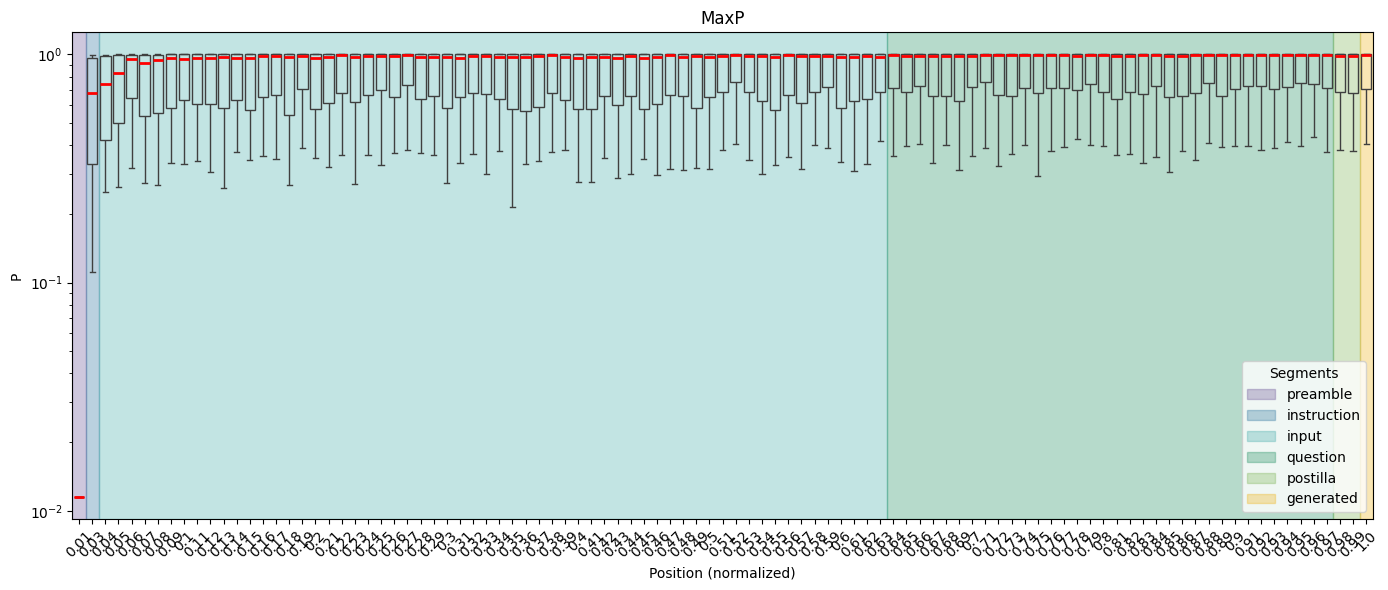

In [400]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

99


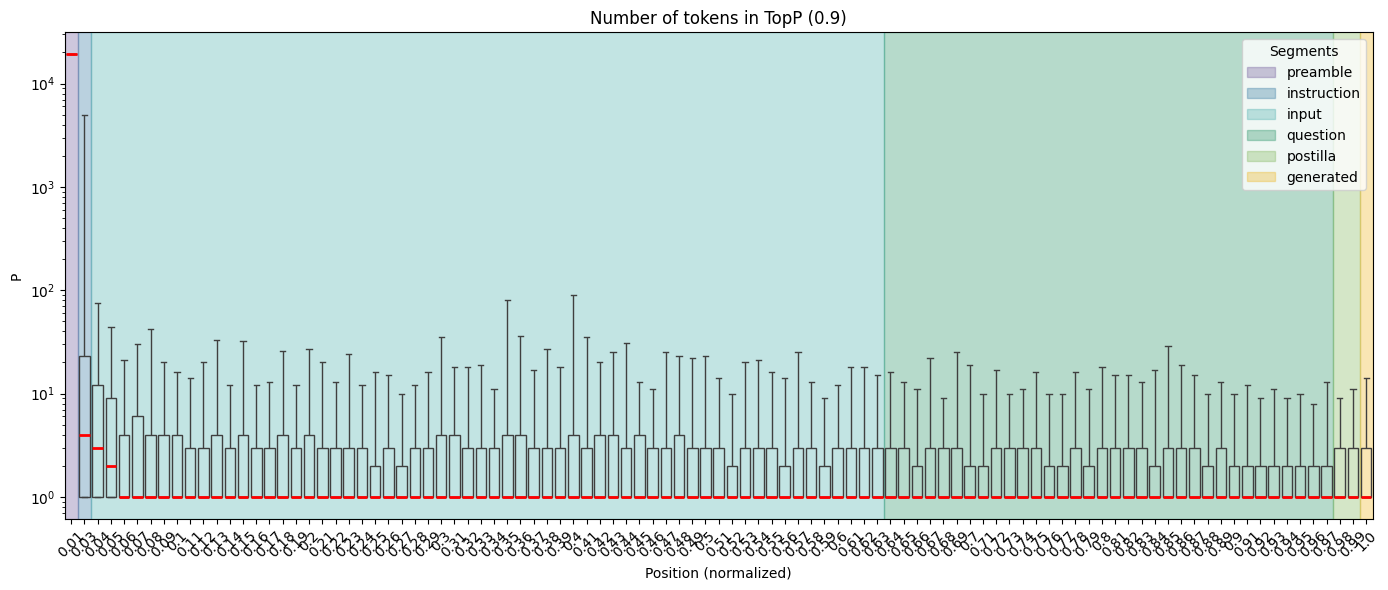

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [403]:
mm[mm.area=='prompt'].true_ent.describe()

count    3.831610e+06
mean     7.413328e-01
std      1.171134e+00
min      0.000000e+00
25%      6.286605e-04
50%      9.805856e-02
75%      1.074651e+00
max      9.495135e+00
Name: true_ent, dtype: float64

In [404]:
mm

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,tok_rel_segm,tok_rel_segm_abs
0,0,0,0,prompt,19127,9.342692,0.011505,0,40,preamble,0,0.000000,0.000000
6,0,0,1,prompt,4954,6.863560,0.110962,0,40,preamble,0,0.025000,0.025000
12,0,0,2,prompt,9,1.748911,0.684082,0,40,preamble,0,0.050000,0.050000
18,0,0,3,prompt,178,4.617726,0.093811,0,40,preamble,0,0.075000,0.075000
24,0,0,4,prompt,5,1.100033,0.811523,0,40,preamble,0,0.100000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23143721,9,99,3266,generated,1,0.007299,1.000000,3240,3270,generated,5,0.998777,5.866667
23143727,9,99,3267,generated,1,1.784877,1.000000,3240,3270,generated,5,0.999083,5.900000
23143733,9,99,3268,generated,1,3.481779,1.000000,3240,3270,generated,5,0.999388,5.933333
23143739,9,99,3269,generated,1,2.092228,1.000000,3240,3270,generated,5,0.999694,5.966667


In [431]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

0.0

In [430]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

0.0

In [429]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

0.0

In [423]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

0.0

In [439]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

5.733333333333334

In [425]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

0.21312056992208012

In [437]:
mm[mm.segment=='generated'].sort_values(['pid', 'tok'], ascending=[True,True]).to_excel("delme.xlsx")

### search prompts for which top-p varies

In [470]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [471]:
mv = mm[mm.pid.isin(variators)]

In [472]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

array([ 9, 14, 17, 18, 45, 53])

In [473]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [474]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

array([ 9, 10, 12, 14, 17, 18, 23, 41, 45, 53, 63, 74, 79, 85, 86, 88, 89,
       94])

In [475]:
set(v1) - set(v2)

set()

In [479]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

,pid,correct
9,9,0.4
14,14,0.4
17,17,0.4
18,18,0.5
45,45,0.5
53,53,0.7


In [480]:
# ??? correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

,pid,correct
12,12,0.4
23,23,0.2
41,41,0.6
63,63,0.4
74,74,0.6
88,88,0.8
89,89,0.7
94,94,0.2


In [490]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,tok_rel_segm,tok_rel_segm_abs,tokzero
12281,0,0,2046,generated,1,9.342692,1.0,2046,2066,generated,5,0.990319,5.000000,0
12287,0,0,2047,generated,1,6.863560,1.0,2046,2066,generated,5,0.990803,5.050000,1
12293,0,0,2048,generated,1,1.748911,1.0,2046,2066,generated,5,0.991288,5.100000,2
12299,0,0,2049,generated,1,4.617726,1.0,2046,2066,generated,5,0.991772,5.150000,3
12305,0,0,2050,generated,1,1.100033,1.0,2046,2066,generated,5,0.992256,5.200000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23143721,9,99,3266,generated,1,0.007299,1.0,3240,3270,generated,5,0.998777,5.866667,26
23143727,9,99,3267,generated,1,1.784877,1.0,3240,3270,generated,5,0.999083,5.900000,27
23143733,9,99,3268,generated,1,3.481779,1.0,3240,3270,generated,5,0.999388,5.933333,28
23143739,9,99,3269,generated,1,2.092228,1.0,3240,3270,generated,5,0.999694,5.966667,29


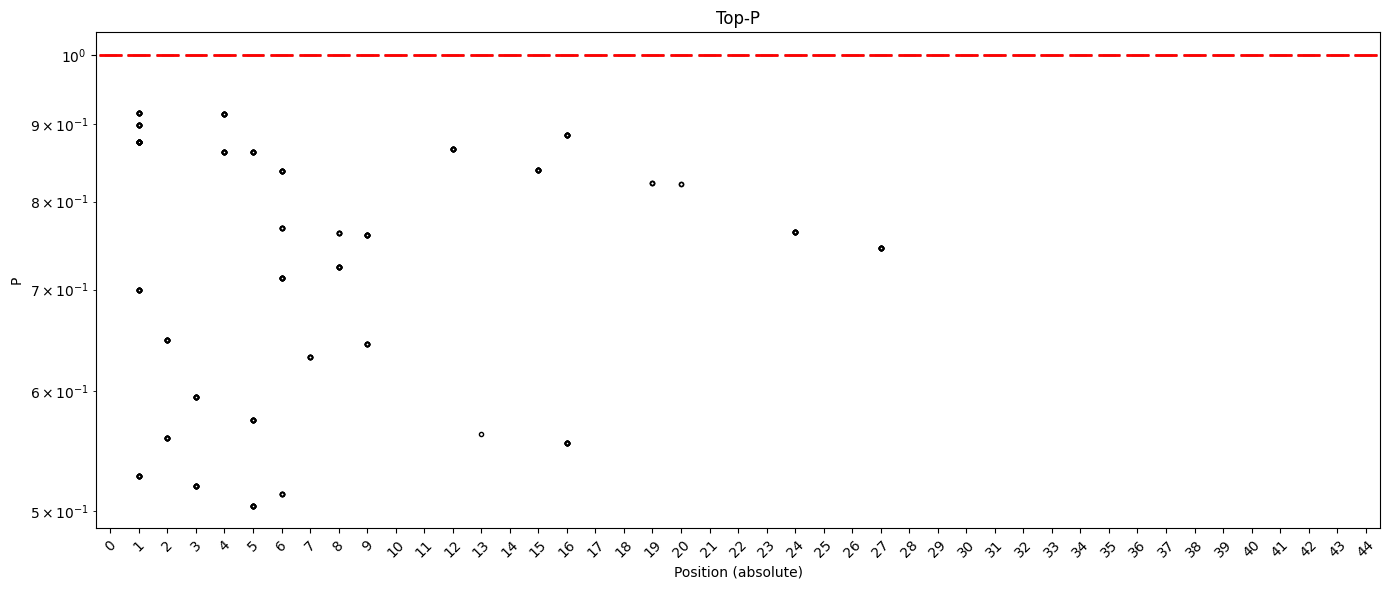

In [496]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

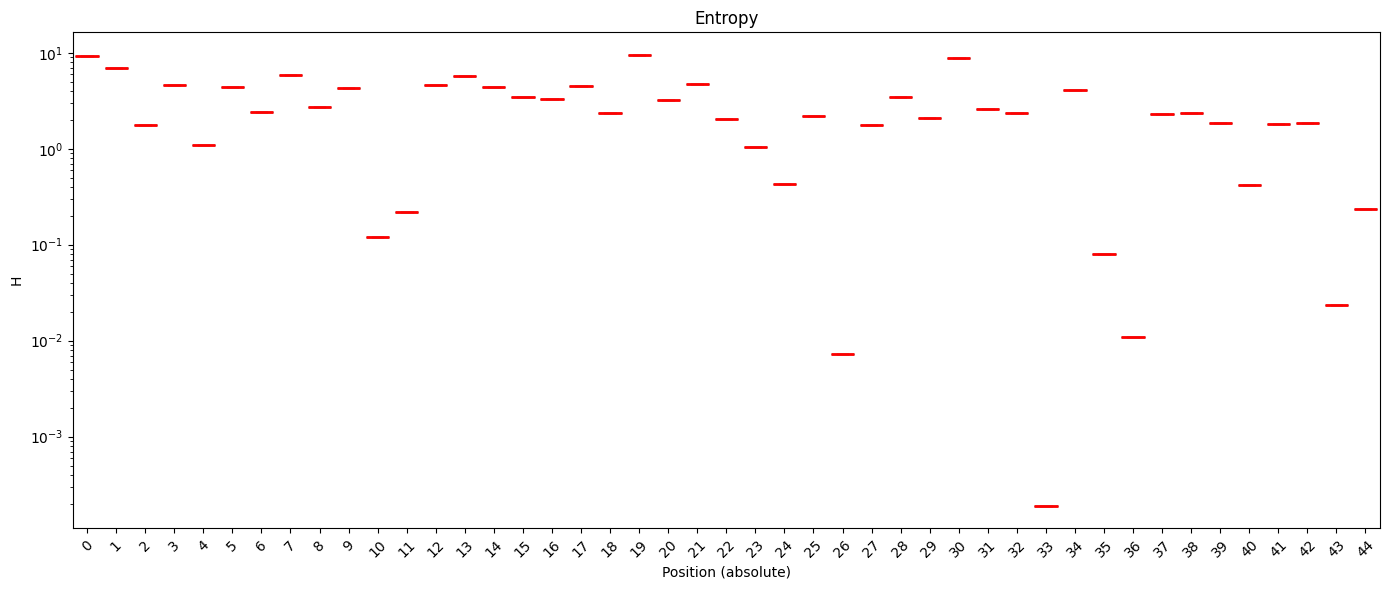

In [497]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

In [341]:
mm.shape

(3857291, 13)

In [342]:
m.shape

(385715, 16)

In [ ]:
# TODO: compare variance in generate (same prompt / multiple prompts)

In [ ]:
# TODO: compare observables grouping by truth

In [ ]:
# TODO: plot truth vs aggregated uncertainty